## Oficina 2: Sistema de classificação de imagens

Você foi contratado para criar um sistema que realiza a classificação de imagens de frutas para uma empresa de e-commerce. O objetivo é que, ao enviar uma imagem, o sistema identifique se a fruta é uma maçã, uma banana ou uma laranja. Sabendo que você possui um banco de imagens já categorizado, explique quais tipos de redes neurais você utilizaria para resolver esse problema, como seria o processo de implementação utilizando Python e quais etapas principais precisam ser seguidas para treinar o modelo.
Padrão de Resposta para a Atividade:

- Indicação clara do tipo de rede neural usada e justificativa do porquê de ser a escolha mais adequada;
- Descrição do processo de pré-processamento das imagens;
- Apresentação do modelo de rede neural em Python, com uma breve explicação de cada camada;
- Compilação e treinamento do modelo, mencionando a função de perda e o otimizador usados;
- Processo de avaliação e validação do modelo;
- Conclusão explicando como o modelo resolverá o problema proposto.

In [22]:
import pandas as pd
import seaborn as sns
import os
import sklearn as sk 
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import zipfile as zf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile


In [23]:

# zip_file_path = '/workspaces/Uece-C-Jovem/Ciência de Dados - Avançado/360fruits (2).zip'

# Unzip the file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#    zip_ref.extractall()

# print("Unzipping completed.")

In [40]:
test_path = ("/workspaces/Uece-C-Jovem/Ciência de Dados - Avançado/aux/360fruits/treinamento")
train_path = ("/workspaces/Uece-C-Jovem/Ciência de Dados - Avançado/aux/360fruits/teste")

In [42]:
img_widht = 100
img_height = 100



In [43]:

data_train = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    labels="inferred",
    label_mode="int",
    image_size=(img_widht, img_height),
    color_mode="rgb",
    batch_size=32,
)

data_test = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    labels="inferred",
    label_mode="int",
    image_size=(img_widht, img_height),
    color_mode="rgb",
    batch_size=32,
)




Found 10190 files belonging to 3 classes.
Found 3403 files belonging to 3 classes.


2025-02-19 20:12:31.228718: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


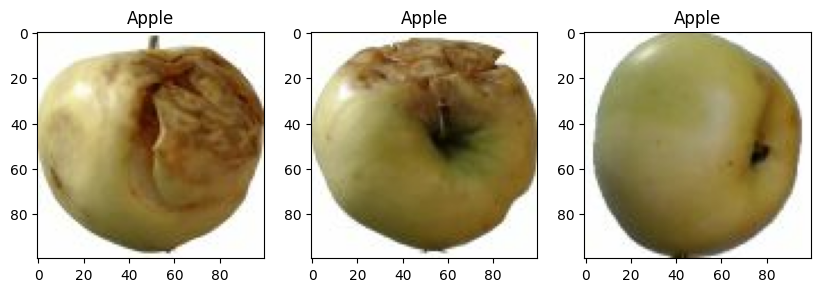

In [46]:

plt.figure(figsize=(10, 10))

for images, labels in data_train.take(1):
    for i in range(3):
       plt.subplot(3,3, i + 1)
       plt.imshow(images[i].numpy().astype("uint8"))
       plt.title(data_train.class_names[labels[i]])

    


In [28]:
from tensorflow.keras import layers, models

model = models.Sequential([
    
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 3)), # Modelo
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(40, activation='softmax')  # 10 classes
   
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
history = model.fit(
    data_train,  # Imagens de treinamento e rótulos de treinamento incluídos no tf.data.Dataset
    epochs=10,    # Número de épocas
    batch_size=64,  # Tamanho do lote
    validation_data=data_test
)

Epoch 1/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 45s 139ms/step - accuracy: 0.7357 - loss: 41.0070 - val_accuracy: 0.8601 - val_loss: 0.6891
Epoch 2/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 44s 139ms/step - accuracy: 0.9832 - loss: 0.0725 - val_accuracy: 0.8278 - val_loss: 1.3158
Epoch 3/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 81s 137ms/step - accuracy: 0.9905 - loss: 0.0443 - val_accuracy: 0.7708 - val_loss: 2.2602
Epoch 4/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 83s 141ms/step - accuracy: 0.9784 - loss: 0.1633 - val_accuracy: 0.8866 - val_loss: 1.0275
Epoch 5/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 43s 136ms/step - accuracy: 0.9988 - loss: 0.0028 - val_accuracy: 0.9001 - val_loss: 0.9332
Epoch 6/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 44s 137ms/step - accuracy: 1.0000 - loss: 1.5211e-04 - val_accuracy: 0.9039 - val_loss: 0.9802
Epoch 7/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 44s 138ms/step - accuracy: 1.0000 - loss: 1.6005e-05 - val_accuracy: 0.9039 - val_loss: 0.9930
Epoch 8/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 82s 137ms/step - accuracy: 1.0000 

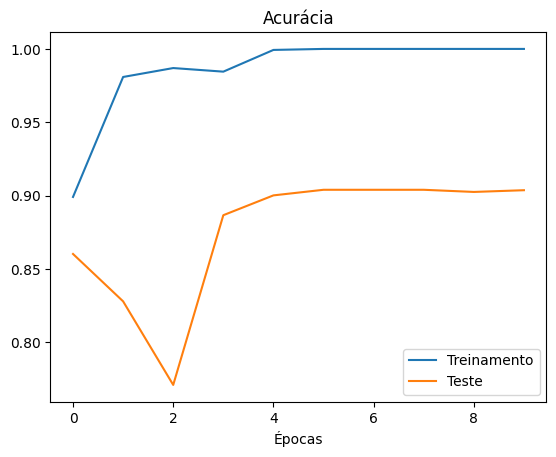

In [30]:
import matplotlib.pyplot as plt

# Plotar acurácia
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Teste')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.legend()
plt.show()

In [31]:
imagem = "/workspaces/Uece-C-Jovem/Ciência de Dados - Avançado/aux/360fruits/R.jpeg"
imagem = tf.keras.preprocessing.image.load_img(imagem , target_size=( img_widht , img_height))
imagem_array = tf.keras.preprocessing.image.img_to_array(imagem)
imagem_bat = tf.expand_dims(imagem_array, 0)

In [35]:
# Predict on the entire test dataset
y_pred = model.predict(data_test)

# Extract true labels from data_test
true_labels = np.concatenate([y for x, y in data_test], axis=0)

# Get the predicted labels
predicted_labels = np.argmax(y_pred, axis=1)

confusion_matrixm = sk.metrics.confusion_matrix(true_labels, predicted_labels)

  3/107 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step

107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step


2025-02-19 19:58:07.361077: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Acurácia final no teste: 1.0000
 17/107 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step

107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.05      0.05      0.05       157
           1       0.05      0.05      0.05       164
           2       0.04      0.04      0.04       148
           3       0.07      0.08      0.07       160
           4       0.03      0.02      0.03       164
           5       0.04      0.04      0.04       161
           6       0.06      0.06      0.06       164
           7       0.02      0.02      0.02       152
           8       0.03      0.04      0.04       164
           9       0.04      0.04      0.04       164
          10       0.06      0.06      0.06       144
          11       0.07      0.08      0.08       166
          12       0.04      0.04      0.04       164
          13       0.07      0.08      0.07       219
          14       0.08      0.09      0.08       234
          15       0.03      0.04      0.03       166
          16   

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


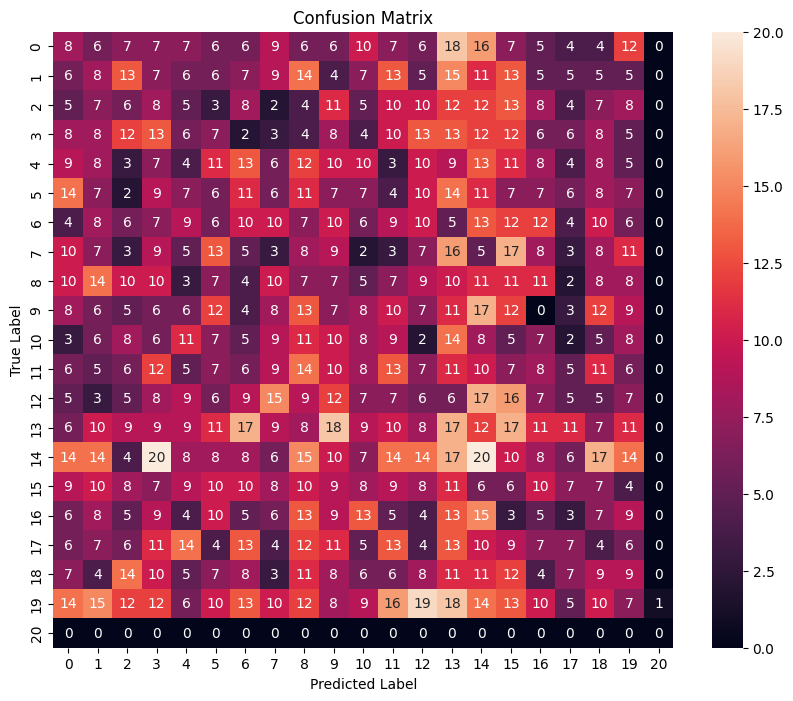

In [39]:
loss, accuracy = history.history['loss'], history.history['accuracy']
print(f"Acurácia final no teste: {accuracy[-1]:.4f}")

# Get predictions for the test dataset
y_pred = model.predict(data_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels from the test dataset
y_true = np.concatenate([y for x, y in data_test], axis=0)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))

# Create and display confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()